In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.io import wavfile

In [4]:
# 観測データを読み込む
sample_rate1, data1 = wavfile.read("music1.wav")
sample_rate2, data2 = wavfile.read("music2.wav")

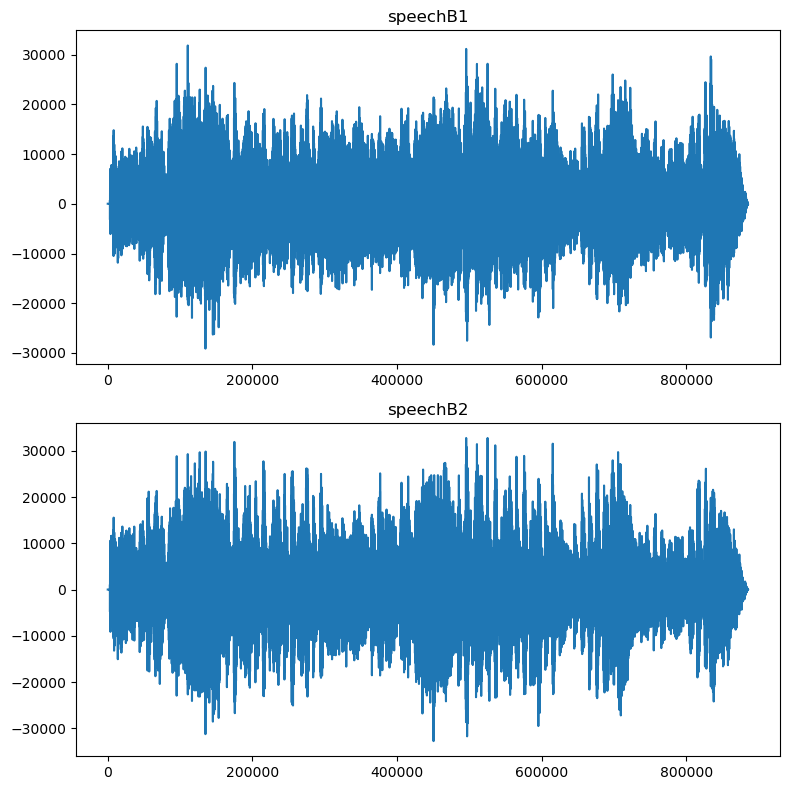

In [6]:
# 観測データを表示してみる
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.title("speechB1")
plt.plot(data1)

plt.subplot(2, 1, 2)
plt.title("speechB2")
plt.plot(data2)

plt.tight_layout()
plt.show()

In [10]:
# サンプル数
n = data1.shape[0]

# 観測データ
mat_x= np.stack((data1, data2)).reshape(2, -1)
mat_x = np.asmatrix(mat_x)

# 平均が0になるように調整
mat_x = mat_x - np.mean(mat_x, axis=1)

# 共分散行列
mat_cov = (mat_x @ mat_x.T) / n
print("共分散行列 mat_cov =\n", mat_cov)

# mat_covを対角化する
eigenvalues, P = np.linalg.eig(mat_cov)
D = np.diag(eigenvalues)
P_inv = np.linalg.inv(P)
print("P = \n", P)
print("D = \n", D)
print("P^-1 = \n", P_inv)

# 行列Vを作る
D2 = np.diag(eigenvalues ** (-1/2))
mat_v = P @ D2 @ P_inv
print("V = \n", mat_v)

# 白色化後の行列
mat_z = mat_v @ mat_x
print("mat_z = \n", mat_z)

# mat_zの共分散行列は単位行列になるはず
print("mat_zの共分散行列(単位行列になるはず、、)\n", np.matmul(mat_z, mat_z.T) / n)

共分散行列 mat_cov =
 [[30024024.94669417 30048001.43586286]
 [30048001.43586286 35162039.25286353]]
P = 
 [[-0.73660912 -0.67631871]
 [ 0.67631871 -0.73660912]]
D = 
 [[ 2435409.71269043        0.        ]
 [       0.         62750654.48686728]]
P^-1 = 
 [[-0.73660912  0.67631871]
 [-0.67631871 -0.73660912]]
V = 
 [[ 0.00040543 -0.00025634]
 [-0.00025634  0.0003616 ]]
mat_z = 
 [[0.00215283 0.00215283 0.00215283 ... 0.00215283 0.00215283 0.00215283]
 [0.00097598 0.00097598 0.00097598 ... 0.00097598 0.00097598 0.00097598]]
mat_zの共分散行列(単位行列になるはず、、)
 [[ 1.00000000e+00 -3.35863348e-14]
 [-3.35863348e-14  1.00000000e+00]]


In [12]:
#　Independent Component Analysis
def ica(seed):
    global mat_z
    mat_z = np.asarray(mat_z)
    np.random.seed(seed)
    w_prev = np.random.rand(2, 1)
    w_prev = w_prev / np.linalg.norm(w_prev)
    w = w_prev
    compare = np.array([[10, 10, 10]])

    while np.linalg.norm(compare) > 1e-9:
        zwz3 = mat_z * ((w_prev.T @ mat_z) ** 3)
        zwz3 = zwz3.mean(axis = 1).reshape(-1, 1)
        w = zwz3 - 3 * w_prev
        if w[0] < 0:
            w = -w
        w = w / np.linalg.norm(w)
        compare = w_prev - w
        w_prev = w
        
    mat_z = np.asmatrix(mat_z)
    return w

In [16]:
w1 = ica(1)
w2 = ica(2)
print(w1,"\n", w2)

[[0.08060801]
 [0.99674588]] 
 [[ 0.99760209]
 [-0.0692103 ]]


In [18]:
# ws[0]とws[1]とws[9]が異なるとわかったので、
mat_w = np.stack((w1, w2)).reshape(2, -1)
print("mat_w = \n", mat_w)

# 信号源データ
mat_y = mat_w @ mat_z
print("mat_y = \n", mat_y)
print(mat_y.shape)

# mat_yの絶対値の最大を確認
print("max of mat_y:\n", mat_y.max(axis=1))
print("min of mat_y:\n", mat_y.min(axis=1))

mat_w = 
 [[ 0.08060801  0.99674588]
 [ 0.99760209 -0.0692103 ]]
mat_y = 
 [[0.00114634 0.00114634 0.00114634 ... 0.00114634 0.00114634 0.00114634]
 [0.00208012 0.00208012 0.00208012 ... 0.00208012 0.00208012 0.00208012]]
(2, 885256)
max of mat_y:
 [[5.65103863]
 [6.93299018]]
min of mat_y:
 [[-4.98554001]
 [-5.47302861]]


In [20]:
# 信号源データを出力する
output1 = (np.asarray(mat_y[0]).flatten() * 32767 / 10).astype(np.int16)
wavfile.write("music_output1.wav", sample_rate1, output1)

output2 = (np.asarray(mat_y[1]).flatten() * 32767 / 10).astype(np.int16)
wavfile.write("music_output2.wav", sample_rate2, output2)